In [6]:
from gmfpp.data_preparation import *

from typing import List, Set, Dict, Tuple, Optional, Any
from collections import defaultdict

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus, relu
from torch.distributions import Distribution, Exponential, Cauchy, HalfCauchy, Normal

from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.transforms import ToTensor
#from functools import reduce
from modelling.ReparameterizedDiagonalGaussian import *
from gmfpp.data_preparation import *
from modelling.CytoVariationalAutoencoder import *
from modelling.VariationalAutoencoder import *
from modelling.ConvVariationalAutoencoder import *
from gmfpp.data_transformers import *
from gmfpp.plotting import *
from modelling.VariationalInference import *

ModuleNotFoundError: No module named 'ReparameterizedDiagonalGaussian'

In [ ]:
rootpath = "../../../"
metadata = read_metadata(rootpath + "data/metadata_small.csv")
metadata = metadata[:2] # @TODO: remove
relative_path = get_relative_image_paths(metadata)
image_paths = [rootpath + "data/" + path for path in relative_path]
images = load_images(image_paths)

train_set = prepare_raw_images(images)
normalize_channels_inplace(train_set)
print(train_set.shape)

channel_first = view_channel_dim_first(train_set)
for i in range(channel_first.shape[0]):
    channel = channel_first[i]
    print("channel {} interval: [{:.2f}; {:.2f}]".format(i, torch.min(channel), torch.max(channel)))


torch.Size([2, 3, 68, 68])
channel 0 interval: [0.04; 1.00]
channel 1 interval: [0.02; 1.00]
channel 2 interval: [0.03; 1.00]


In [2]:
# VAE
image_shape = np.array([3, 68, 68])
latent_features = 256
vae = CytoVariationalAutoencoder(image_shape, latent_features)
#vae = VariationalAutoencoder(image_shape, latent_features)

beta = 1
vi = VariationalInference(beta=beta)

# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3, weight_decay=10e-4)

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

num_epochs = 5000
batch_size = 2
print_every = 100

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")


train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

# move the model to the device
vae = vae.to(device)

NameError: name 'CytoVariationalAutoencoder' is not defined

In [3]:
# training..

for epoch in range(num_epochs):
    
    training_epoch_data = defaultdict(list)
    vae.train()

    for x in train_loader:
        x = x.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vi(vae, x)

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(vae.parameters(), 100000)
        optimizer.step()

        # gather data for the current batch
        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]

    
    # gather data for the full epoch
    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

    # Evaluate on a single batch, do not propagate gradients
    with torch.no_grad():
        vae.eval()

        # Just load a single batch from the test loader
        '''x, y = next(iter(test_loader))'''
        x = x.to(device)

        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vi(vae, x)

        # gather data for the validation step
        for k, v in diagnostics.items():
            validation_data[k] += [v.mean().item()]

    if epoch % print_every == 0:
        print(f"epoch: {epoch}/{num_epochs}")
        print("training | elbo: {:2f}, log_px: {:.2f}, kl: {:.2f}:".format(np.mean(training_epoch_data["elbo"]), np.mean(training_epoch_data["log_px"]), np.mean(training_epoch_data["kl"])))
        print("validation | elbo: {:2f}, log_px: {:.2f}, kl: {:.2f}:".format(np.mean(validation_data["elbo"]), np.mean(validation_data["log_px"]), np.mean(validation_data["kl"])))


NameError: name 'num_epochs' is not defined

In [15]:
x = train_set[0]

#plot_image(x)


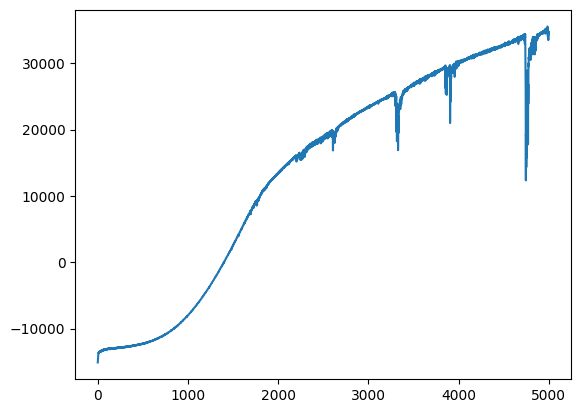

In [16]:
plt.plot(training_data["elbo"])

/Users/simondanieleiriksson/Documents/DTU-kurser/Deep learning/Project/code/DeepLearning2022/refactor/gmfpp/plotting.py:40: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


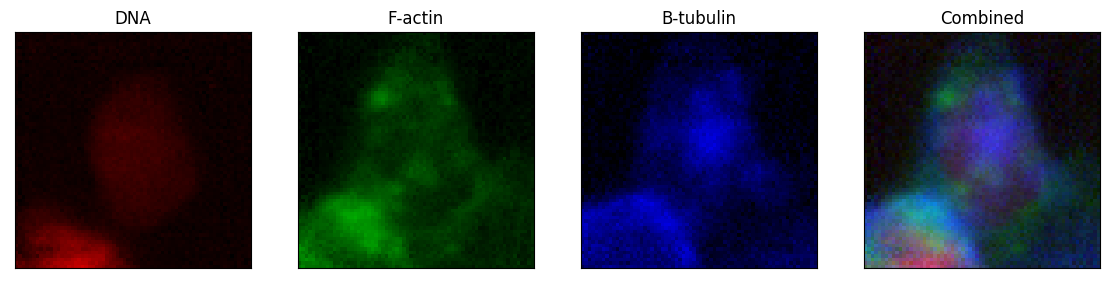

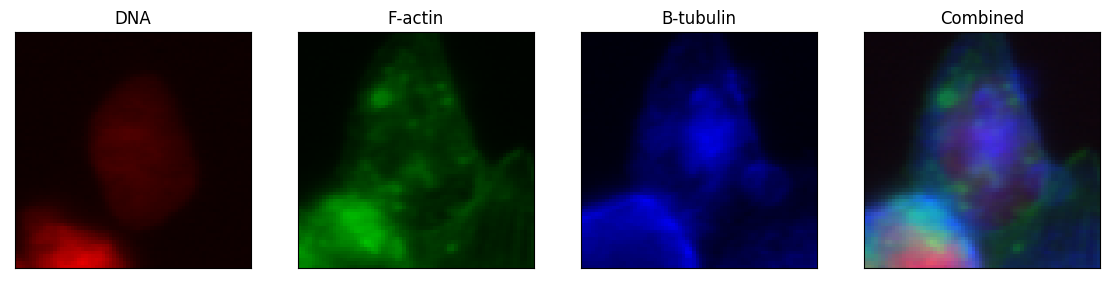

In [17]:
vae.eval() # because of batch normalization
outputs = vae(x[None,:,:,:])
px = outputs["px"]
x_reconstruction = px.sample()
x_reconstruction = x_reconstruction[0]
plot_image_channels(x_reconstruction)
plot_image_channels(x)

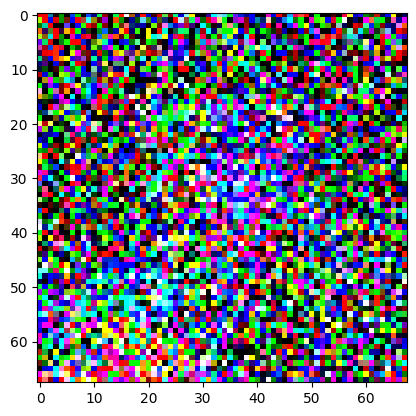

In [19]:

x_reconstruction = px.sample()
x_reconstruction = x_reconstruction[0]
plt.imshow(view_as_image_plot_format(clip_image_to_zero_one(x_reconstruction)))